
**Research Paper Labelling**
This document uses LLM models to identify if a research paper includes generative AI and machine learning in retail field based on the abstract of the paper. <br><br>

The documents are research papers from Scopus database. <br>Below query is used to pull documents. Total 326 documents are found. <br>

( TITLE-ABS-KEY ( "generative" OR "gan" OR "vae" OR "autoencoder" OR "rag" OR "llm" OR "Generative Models" OR "Transformer Model" OR "GAN" ) AND LANGUAGE ( english ) AND TITLE-ABS-KEY ( "consumer" OR "retail" OR “commerce” OR “marketing” OR  "commerce") AND TITLE-ABS-KEY ( "ai" OR "artificial intelligence" ) ) AND ( LIMIT-TO ( DOCTYPE , "cp" ) OR LIMIT-TO ( DOCTYPE , "ar" ) OR LIMIT-TO ( DOCTYPE , "ch" ) ) AND ( LIMIT-TO ( SUBJAREA , "SOCI" ) OR LIMIT-TO ( SUBJAREA , "DECI" ) OR LIMIT-TO ( SUBJAREA , "ECON" ) OR LIMIT-TO ( SUBJAREA , "PSYC" ) OR LIMIT-TO ( SUBJAREA , "ARTS" ) OR LIMIT-TO ( SUBJAREA , "BUSI" ) ) AND ( LIMIT-TO ( LANGUAGE , "English" ) ) AND (PUBYEAR > 2019)

- Ran the query and extracted abstract and other fields of research papers in csv file from Scopus database
- Using 'databricks-mixtral-8x7b-instruct' endpoint based LLM model and prompts, classified each paper if it refers to any Gen-AI technology or not and if yes, identified themes in that. If not, then provided justification.
- Based on the research papers that indicated reference of Gen-AI, identified most frequent, medium and least researched themes and generated graphs.
- Also, by using same model with different prompts, I classified each theme as technology/use-case/other and generated plots. <br>
- Further I would like to check if the papers that indicated use of Gen-AI, if they shows a positive impact on retail use case through thise technology or not.

In [0]:
%pip install openpyxl

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 5.1 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
!pip install --upgrade openai  

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.3/472.3 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.0/345.0 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Not uninstalling typing-extensions at /databricks/python3/lib/python3.10/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-0a5ae33c-8cc8-4940-9bc4-05e2a334809d
    Can't uninstall 'typing_extensions'. No files were found to uninstall.
  Attempting uninstall: openai
    Found existing installation: openai 0.28.1
    Not uninstalling openai at /databricks/python3

In [0]:
%pip install langchain==0.1.20 langchain_core==0.1.52 langchain_community==0.0.38 langchain-openai==0.1.7
# %pip install openai==1.35.3
%pip install --upgrade typing_extensions==4.12.2

dbutils.library.restartPython()

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.8/311.8 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.3/130.3 kB 10.1 MB/s eta 0:00:00
  Attempting uninstall: tiktoken
    Found existing installation: tiktoken 0.5.2
    Not uninstalling tiktoken at /databricks/python3/lib/python3.10/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-0a5ae33c-8cc8-4940-9bc4-05e2a334809d
    Can't uninstall 'tiktoken'. No files were found to uninstall.
  Atte

In [0]:
from pyspark.sql.types import StructType,StructField, StringType, IntegerType
from pyspark.sql.functions import *
from pyspark.sql.functions import concat, col, lit
import pyspark.sql.functions as F
from pyspark.sql.window import Window 
import math
import pandas as pd
import numpy as np
import os
from pyspark.sql.types import *
import pyspark.sql.functions as F
from openai import OpenAI
import time
import requests
import asyncio
from tenacity import retry, stop_after_attempt, wait_random_exponential
from concurrent.futures import ThreadPoolExecutor
import nest_asyncio
from langchain_core.prompts import PromptTemplate
import json

In [0]:
file_path = '/Volumes/cmidev/default/preventech/data/user_files/gf591/ML/fads/scopus.csv'

In [0]:
df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(file_path).toPandas()
df.head(5)

,Authors,Author full names,Author(s) ID,Title,Year,Source title,Volume,Issue,Art. No.,Page start,Page end,Page count,Cited by,DOI,Link,Abstract,Author Keywords,Index Keywords,Document Type,Publication Stage,Open Access,Source,EID
0,Chen Z.; Chan J.,"Chen, Zenan (59487295100); Chan, Jason (565276...",59487295100; 56527614500,Large Language Model in Creative Work: The Rol...,2024,Management Science,70,12,None,9101.0,9117.0,16.0,0,10.1287/mnsc.2023.03014,https://www.scopus.com/inward/record.uri?eid=2...,"Since the launch of ChatGPT in December 2022, ...",advertising; collaboration modality; large lan...,Marketing; Advertizing; Business outcomes; Col...,Article,Final,None,Scopus,2-s2.0-85206487214
1,Sudha L.; Aruna K.B.; Sureka V.; Niveditha M.;...,"Sudha, Lakshmanan (57207217074); Aruna, Kari B...",57207217074; 57200138702; 57200141626; 5945920...,Semantic Image Synthesis from Text: Current Tr...,2025,EAI Endorsed Transactions on Internet of Things,11,None,None,NaN,NaN,NaN,0,10.4108/eetiot.5336,https://www.scopus.com/inward/record.uri?eid=2...,"Text-to-image generation, a captivating inters...",Computer Vision; Ethical AI; Generative Advers...,None,Article,Final,All Open Access; Gold Open Access,Scopus,2-s2.0-85211156231
2,Rameshbhai K.M.; Prakash P.,"Rameshbhai, Khant Mayank (59409840300); Prakas...",59409840300; 59409789900,Generative AI and Consumer Behavior,2025,Minds Unveiled: Exploring the Effects of Gener...,None,None,None,30.0,41.0,11.0,0,10.4324/9781032711089-3,https://www.scopus.com/inward/record.uri?eid=2...,There is a huge impact of generative artificia...,None,None,Book chapter,Final,None,Scopus,2-s2.0-85209013354
3,Shore A.; Tiwari M.; Tandon P.; Foropon C.,"Shore, Adam (57991342600); Tiwari, Manisha (57...",57991342600; 57221261105; 57222742326; 5557089...,Building entrepreneurial resilience during cri...,2024,Technovation,135,None,103063,NaN,NaN,NaN,10,10.1016/j.technovation.2024.103063,https://www.scopus.com/inward/record.uri?eid=2...,"Recently, Gen AI has garnered significant atte...",Dynamic capability view; Entrepreneurial orien...,Commerce; Competition; Enterprise resource man...,Article,Final,All Open Access; Hybrid Gold Open Access,Scopus,2-s2.0-85196638208
4,Singh B.; Kaunert C.,"Singh, Bhupinder (58806881100); Kaunert, Chris...",58806881100; 35976174500,Radiant Horizons of Augmented Reality and Virt...,2025,Minds Unveiled: Exploring the Effects of Gener...,None,None,None,262.0,280.0,18.0,0,10.4324/9781032711089-19,https://www.scopus.com/inward/record.uri?eid=2...,Virtual reality (VR) with augmented reality (A...,None,None,Book chapter,Final,None,Scopus,2-s2.0-85209016182


In [0]:
parser_system_prompt = "You are a AI assistant, who will be reviewing research papers to find out how generative AI technology is used in retail industry if research paper abstract has a mention of the same. You need to identify which themes are mentioned if those papers mention about usage of generative AI technology in retail market. Please generate result as True or False if any themes are mentioned and list the themes, also provide reference sentences from given text based on this decision is made. Please provide the expected output in the format of {'Label':'True/False', 'Themes':['theme1','theme2'],'Reference':'sentence'}. If an abstract text does not have a mention of using generative AI technology, then leave Theme field as blank and add justification in the Reference field. If the Label is True, do not generate any explaination text, only generate expected output."


        
parser_user_prompt = "Example1 Input= {'EID': '2-s2.0-85206487214',  'Abstract': 'Here, we investigate and compare two ways of working with LLMs: (1) using LLMs as “ghostwriters,” which assume the main role of the content generation task, and (2) using LLMs as “sounding boards” to provide feedback on human-created content. We measure the quality of the ads using the number of clicks generated by the created ads on major social media platforms. Our results show that different collaboration modalities can result in very different outcomes for different user types. Using LLMs as sounding boards enhances the quality of the resultant ad copies for nonexperts. However, using LLMs as ghostwriters did not provide significant benefits and is, in fact, detrimental to expert users. We rely on textual analyses to understand the mechanisms, and we learned that using LLMs as ghostwriters produces an anchoring effect, which leads to lower-quality ads. On the other hand, using LLMs as sounding boards helped nonexperts achieve ad content with low semantic divergence to content produced by experts, thereby closing the gap between the two types of users.'}. Expeced output: {'Label:'True', 'Themes':['text-to-image generation','e-commerce']',Reference':'Here, we investigate and compare two ways of working with LLMs: (1) using LLMs as “ghostwriters,” which assume the main role of the content generation task, and (2) using LLMs as “sounding boards” to provide feedback on human-created content.'}. Example2 Input= {'EID': '2-s2.0-85209016182', 'Abstract': 'Virtual reality (VR) with augmented reality (AR) has drastically changed the market for customer-focused product selections. These immersive technologies present organizations with previously unheard-of chances to interact and engage customers in fresh and creative ways. Customers may see items in real world settings, thanks to AR and VR, which promotes more customized and informed decision-making. In addition to disrupting the customer experience, the convergence of AR, VR, and AI creates opportunities for businesses to innovate and meet shifting consumer expectations in the dynamic world of technology-driven commerce. In the framework of generative artificial intelligence (AI) solutions, this chapter investigates the revolutionary effects of AR and VR on customer-centric product decisions. © 2025 selection and editorial matter, Raul V. Rodriguez and Hemachandran K.'}. Expected output is: '{'Label':'False', 'Themes':[],'Reference':'Justification:In the given text, there is no mention of the usage of generative AI technology in the retail industry. The text discusses the impact of virtual reality (VR) and augmented reality (AR) on customer-centric product decisions in the context of generative AI solutions, but it does not provide any specific details about how generative AI is being used in this context.'}'"

parser_user_prompt_combo = "Please examin given text and generate expected output for below set of input. "


In [0]:
# parser_text = "{'EID': '2-s2.0-85211156231', 'Abstract': 'Text-to-image generation, a captivating intersection of natural language processing and computer vision, has undergone a remarkable evolution in recent years. This research paper provides a comprehensive review of the state-of-the-art in text-to-image generation techniques, highlighting key advancements and emerging trends. We begin by surveying the foundational models, with a focus on Generative Adversarial Networks (GANs) and their pivotal role in generating realistic and diverse images from textual descriptions. We delve into the intricacies of training data, model architectures, and evaluation metrics, offering insights into the challenges and opportunities in this field. Furthermore, this paper explores the synergistic relationship between natural language processing and computer vision, showcasing multimodal models like DALL-E and CLIP. These models not only generate images from text but also understand the contextual relationships between textual descriptions and images, opening avenues for content recommendation, search engines, and visual storytelling. The paper discusses applications spanning art, design, e-commerce, healthcare, and education, where text-to-image generation has made significant inroads. We highlight the potential of this technology in automating content creation, aiding in diagnostics, and transforming the fashion and e-commerce industries. However, the journey of text-to-image generation is not without its challenges. We address ethical considerations, emphasizing responsible AI and the mitigation of biases in generated content. We also explore interpretability and model transparency, critical for ensuring trust and accountability. © 2024 L. Sudha et al.'}"

parser_text ="{'EID': '2-s2.0-85209016182', 'Abstract': 'Virtual reality (VR) with augmented reality (AR) has drastically changed the market for customer-focused product selections. These immersive technologies present organizations with previously unheard-of chances to interact and engage customers in fresh and creative ways. Customers may see items in real world settings, thanks to AR and VR, which promotes more customized and informed decision-making. In addition to disrupting the customer experience, the convergence of AR, VR, and AI creates opportunities for businesses to innovate and meet shifting consumer expectations in the dynamic world of technology-driven commerce. In the framework of generative artificial intelligence (AI) solutions, this chapter investigates the revolutionary effects of AR and VR on customer-centric product decisions. © 2025 selection and editorial matter, Raul V. Rodriguez and Hemachandran K.'}"

In [0]:

from openai import OpenAI
import os
DATABRICKS_TOKEN = dbutils.notebook.entry_point.getDbutils().notebook().getContext().apiToken().get()

# print(DATABRICKS_TOKEN)
# Set the OpenAI API key as an environment variable
DATABRICKS_TOKEN = dbutils.notebook.entry_point.getDbutils().notebook().getContext().apiToken().get()

os.environ['OPENAI_API_KEY'] = DATABRICKS_TOKEN#os.environ.get('DATABRICKS_TOKEN')

client = OpenAI(
  api_key=os.environ['OPENAI_API_KEY'],
  base_url="https://adb-7018564609060221.1.azuredatabricks.net/serving-endpoints"
)

chat_completion = client.chat.completions.create(
  messages=[

    {"role": "system", "content": parser_system_prompt +" "+ parser_user_prompt},
    {"role": "user", "content": parser_user_prompt_combo + " " + parser_text}

  ],
  model="databricks-mixtral-8x7b-instruct",
  max_tokens=8192
)

options = (chat_completion.choices[0].message.content)
print(options)                   


{'Label':'False', 'Themes':[],'Reference':'Justification:In the given text, there is no mention of the usage of generative AI technology in the retail industry. The text discusses the impact of virtual reality (VR) and augmented reality (AR) on customer-centric product decisions in the context of generative AI solutions, but it does not provide any specific details about how generative AI is being used in this context.'}


In [0]:
from pyspark.sql.functions import col
from pyspark.sql.functions import split  

def ReadRuleTextData():
  
   
    #read only columns of interest
    df_ = df[['EID','Title','Abstract']]
    
   
    # Create Spark DataFrame from Pandas DataFrame
    df_spark = spark.createDataFrame(df_)
   

    #Drop NA
    df_spark = df_spark.na.drop(subset=["EID"])
    display(df_spark.head(5))
    return df_spark
df_sp=ReadRuleTextData()

EID,Title,Abstract
2-s2.0-85206487214,Large Language Model in Creative Work: The Role of Collaboration Modality and User Expertise,"Since the launch of ChatGPT in December 2022, large language models (LLMs) have been rapidly adopted by businesses to assist users in a wide range of open-ended tasks, including creative work. Although the versatility of LLM has unlocked new ways of human-artificial intelligence collaboration, it remains uncertain how LLMs should be used to enhance business outcomes. To examine the effects of human-LLM collaboration on business outcomes, we conducted an experiment where we tasked expert and nonexpert users to write an ad copy with and without the assistance of LLMs. Here, we investigate and compare two ways of working with LLMs: (1) using LLMs as “ghostwriters,” which assume the main role of the content generation task, and (2) using LLMs as “sounding boards” to provide feedback on human-created content. We measure the quality of the ads using the number of clicks generated by the created ads on major social media platforms. Our results show that different collaboration modalities can result in very different outcomes for different user types. Using LLMs as sounding boards enhances the quality of the resultant ad copies for nonexperts. However, using LLMs as ghostwriters did not provide significant benefits and is, in fact, detrimental to expert users. We rely on textual analyses to understand the mechanisms, and we learned that using LLMs as ghostwriters produces an anchoring effect, which leads to lower-quality ads. On the other hand, using LLMs as sounding boards helped nonexperts achieve ad content with low semantic divergence to content produced by experts, thereby closing the gap between the two types of users. Copyright: © 2024 INFORMS."
2-s2.0-85211156231,Semantic Image Synthesis from Text: Current Trends and Future Horizons in Text-to-Image Generation,"Text-to-image generation, a captivating intersection of natural language processing and computer vision, has undergone a remarkable evolution in recent years. This research paper provides a comprehensive review of the state-of-the-art in text-to-image generation techniques, highlighting key advancements and emerging trends. We begin by surveying the foundational models, with a focus on Generative Adversarial Networks (GANs) and their pivotal role in generating realistic and diverse images from textual descriptions. We delve into the intricacies of training data, model architectures, and evaluation metrics, offering insights into the challenges and opportunities in this field. Furthermore, this paper explores the synergistic relationship between natural language processing and computer vision, showcasing multimodal models like DALL-E and CLIP. These models not only generate images from text but also understand the contextual relationships between textual descriptions and images, opening avenues for content recommendation, search engines, and visual storytelling. The paper discusses applications spanning art, design, e-commerce, healthcare, and education, where text-to-image generation has made significant inroads. We highlight the potential of this technology in automating content creation, aiding in diagnostics, and transforming the fashion and e-commerce industries. However, the journey of text-to-image generation is not without its challenges. We address ethical considerations, emphasizing responsible AI and the mitigation of biases in generated content. We also explore interpretability and model transparency, critical for ensuring trust and accountability. © 2024 L. Sudha et al."
2-s2.0-85209013354,Generative AI and Consumer Behavior,"There is a huge impact of generative artificial intelligence (AI) on consumer behavior realms. This study aims to address the recent innovation in generative AI and how it analyzes and enhances the whole customer experience for companies that use such technologies as an edge over their competitors. The role

In [0]:
## Converting from dataframe to list representation -- faster than creating a UDF for these tasks

data = df_sp.select(col("EID"), col("Abstract")).collect()

initial_cal_llm_call_parser = []
for i in data:
    
    initial_cal_llm_call_parser.append({"EID":i['EID'], 
                                        "Abstract": i['Abstract']})

print(len(initial_cal_llm_call_parser))

325


In [0]:
# import json
# from pyspark.sql import Row

# output_text = "{'Label':'True', 'Themes':['text-to-image generation', 'e-commerce'],'Reference':'This paper explores the synergistic relationship between natural language processing and computer vision, showcasing multimodal models like DALL-E and CLIP. These models not only generate images from text but also understand the contextual relationships between textual descriptions and images, opening avenues for content recommendation, search engines, and visual storytelling. The paper discusses applications spanning ... e-commerce, where text-to-image generation has made significant inroads.'}"

# # Convert the string to a dictionary
# output_dict = json.loads(output_text.replace("'", "\""))

# # Create a Row object
# row = Row(Label=output_dict['Label'], Themes=output_dict['Themes'], Reference=output_dict['Reference'])

# # Create a DataFrame
# df = spark.createDataFrame([row])

# display(df)

Label,Themes,Reference
True,"List(text-to-image generation, e-commerce)","This paper explores the synergistic relationship between natural language processing and computer vision, showcasing multimodal models like DALL-E and CLIP. These models not only generate images from text but also understand the contextual relationships between textual descriptions and images, opening avenues for content recommendation, search engines, and visual storytelling. The paper discusses applications spanning ... e-commerce, where text-to-image generation has made significant inroads."


In [0]:
def CallParserLLM(text,eid=0):
    import time
     # Wait time
    time.sleep(5)
    # print("Calling parser with text:", text)
    #replace "" with single quote in text
    # try:
    #     text_= str(text).replace('"', "'")
    # except:
    #     text_ = text

    from openai import OpenAI
    import os
    # Set the OpenAI API key as an environment variable
    DATABRICKS_TOKEN = dbutils.notebook.entry_point.getDbutils().notebook().getContext().apiToken().get()

    os.environ['OPENAI_API_KEY'] = DATABRICKS_TOKEN#os.environ.get('DATABRICKS_TOKEN')

    client = OpenAI(
    api_key=os.environ['OPENAI_API_KEY'],
    base_url="https://adb-7018564609060221.1.azuredatabricks.net/serving-endpoints"
    )

    chat_completion = client.chat.completions.create(
    messages=[        
        {"role": "system", "content": parser_system_prompt +" "+ parser_user_prompt},
        {"role": "user", "content": parser_user_prompt_combo + " " + text}

    ],
    model="databricks-mixtral-8x7b-instruct",
    max_tokens=28000
    )

    output_text = (chat_completion.choices[0].message.content)
    # print("original output:", output_text)

    # options = options.replace("\\", "")
    try:
        ## Extract Label, Themes and Reference fields from the output and create a datagrame
        # # Convert the string to a dictionary
        
        output_dict = json.loads(output_text.replace("'", "\""))

        # # Create a Row object
        row = Row(EID=eid, Label=output_dict['Label'], Themes=output_dict['Themes'], Reference=output_dict['Reference'])
    except:
        row = Row(EID=eid, Label=None, Themes=None, Reference=None)
    # print(row)
    return row


In [0]:
a = initial_cal_llm_call_parser[1]
# b = str(a).replace("'", '"')
b
combo = CallParserLLM(str(a),eid=0)
print(combo)

Row(EID=0, Label='True', Themes=['text-to-image generation', 'e-commerce'], Reference='The paper discusses applications spanning art, design, e-commerce, healthcare, and education, where text-to-image generation has made significant inroads. We highlight the potential of this technology in automating content creation, aiding in diagnostics, and transforming the fashion and e-commerce industries.')


In [0]:
id = df['EID'].tolist()


In [0]:
result = []
ids=[]

In [0]:
len(initial_cal_llm_call_parser)

325

In [0]:
from pyspark.sql.types import StructType, StructField, StringType

# Define the schema
schema = StructType([
    StructField("EID", StringType(), True),
    StructField("Label", StringType(), True),
    StructField("Themes", StringType(), True),
    StructField("Reference", StringType(), True)
    # Add other fields as necessary
])

for i in range(len(initial_cal_llm_call_parser)):
# for i in range(5):

    # print(i)
    print(id[i])
    combo = CallParserLLM(str(initial_cal_llm_call_parser[i]), eid=id[i])
    combo_data = [(combo.EID, combo.Label, combo.Themes, combo.Reference)]
    combo_df = spark.createDataFrame(combo_data, schema)
    if i == 0:
        final_df = combo_df
    else:
        final_df = final_df.union(combo_df)
    # result.append(combo)
    # ids.append(id[i])

display(final_df)

2-s2.0-85206487214
2-s2.0-85211156231
2-s2.0-85209013354
2-s2.0-85196638208
2-s2.0-85209016182
2-s2.0-85192157885
2-s2.0-85206256893
2-s2.0-85173499156
2-s2.0-85214499496
2-s2.0-85213116355
2-s2.0-85199754641
2-s2.0-85188582458
2-s2.0-85182461630
2-s2.0-85216098451
2-s2.0-85205224223
2-s2.0-85216644291
2-s2.0-85189983811
2-s2.0-85209003955
2-s2.0-85203807460
2-s2.0-85196355033
2-s2.0-85210037351
2-s2.0-85200775428
2-s2.0-85215507574
2-s2.0-85213285254
2-s2.0-85206625640
2-s2.0-85207795058
2-s2.0-85201936542
2-s2.0-85180167366
2-s2.0-85200833840
2-s2.0-85190115641
2-s2.0-85208769402
2-s2.0-85206240814
2-s2.0-85196533015
2-s2.0-85201460786
2-s2.0-85188503942
2-s2.0-85216778652
2-s2.0-85215957773
2-s2.0-85197461723
2-s2.0-85213301440
2-s2.0-85205122773
2-s2.0-85217184486
2-s2.0-85204210958
2-s2.0-85198419697
2-s2.0-85212762609
2-s2.0-85199526766
2-s2.0-85198648352
2-s2.0-85207499611
2-s2.0-85210044748
2-s2.0-85196408541
2-s2.0-85216236289
 aiming to showcase case studies
2-s2.0-8520287063

EID,Label,Themes,Reference
2-s2.0-85206487214,True,"[human-AI collaboration, ad copy generation]","Here, we investigate and compare two ways of working with LLMs: (1) using LLMs as “ghostwriters,” which assume the main role of the content generation task, and (2) using LLMs as “sounding boards” to provide feedback on human-created content."
2-s2.0-85211156231,True,"[text-to-image generation, e-commerce]","The paper discusses applications spanning art, design, e-commerce, healthcare, and education, where text-to-image generation has made significant inroads. We highlight the potential of this technology in automating content creation, aiding in diagnostics, and transforming the fashion and e-commerce industries."
2-s2.0-85209013354,null,null,null
2-s2.0-85196638208,False,[],"Justification: The given text does not mention the usage of generative AI technology specifically in the retail industry. The text discusses the usage of Gen AI by small and medium-sized firms in general, and how it influences their entrepreneurial orientation and ability to build entrepreneurial resilience amidst market turbulence."
2-s2.0-85209016182,False,[],"Justification: In the given text, there is no mention of the usage of generative AI technology in the retail industry. The text discusses the impact of virtual reality (VR) and augmented reality (AR) on customer-centric product decisions in the context of generative AI solutions, but it does not provide any specific details about how generative AI is being used in this context."
2-s2.0-85192157885,True,"[generative AI tools, personalized recommendations, interactive shopping experiences]","This article sheds light on the profound impact of technology on consumer behavior, specifically focusing on the rise of generative AI tools. It highlights how these advancements have revolutionized consumer engagement, purchase decision-making, and technology interaction. The article underscores the transformative potential of generative AI in shaping consumer behavior through personalized recommendations and interactive shopping experiences."
2-s2.0-85206256893,True,"[generative AI-based chatbots, retailing businesses]","Generative AI-based chatbots have surfaced as a magical tool, revolutionizing the service industry. The results disseminate the indispensability of AI-enabled chatbots for retailing businesses to attain commercial competency."
2-s2.0-85173499156,False,[],"Justification: In the given text, there is a mention of generative AI technology but it does not provide any specific details about its usage in the retail industry. The text discusses the potential and applications of generative AI in various industries including retailing, but it is not clear if or how it is currently being used in that context."
2-s2.0-85214499496,True,"[data generation, data analysis, synthetic data, few-shot learning, retrieval-augmented generation]","In qualitative research, they show that LLMs can assist in both data generation and analysis; LLMs effectively create sample characteristics, generate synthetic respondents, and conduct and moderate in-depth interviews. The AI–human hybrid generates information-rich, coherent data that surpasses human-only data in depth and insightfulness and matches human performance in data analysis tasks of generating themes and summaries. The LLM correctly picks the answer direction and valence, with the quality of synthetic data significantly improving through few-shot learning and retrieval-augmented generation."
2-s2.0-85213116355,null,null,null


In [0]:
final_df.write.csv('/Volumes/cmidev/default/preventech/data/user_files/gf591/ML/fads/gen_ai_themes.csv', header=True)

In [0]:
final_df_path= '/Volumes/cmidev/default/preventech/data/user_files/gf591/ML/fads/gen_ai_themes.csv'
final_df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(final_df_path).toPandas()
final_df.head(5)

,EID,Label,Themes,Reference
0,2-s2.0-85211805262,True,"[interactive and immersive advertising, person...",Generative AI is revolutionizing interactive a...
1,2-s2.0-85198834469,True,"[product recommendation, large language models...",Product recommendation systems are an essentia...
2,2-s2.0-85201205614,True,"[chatbots as sales assistants, large language ...",It is expected to deploy chatbots as sales ass...
3,2-s2.0-85199110741,True,"[product design, catalog creation, customer se...","Technology enablers, particularly AI-based too..."
4,2-s2.0-85216098451,True,"[generative AI technologies, marketing communi...",This research examines whether generative AI c...


In [0]:
final_df_true = final_df[final_df['Label']==True]
final_df_true

,EID,Label,Themes,Reference
0,2-s2.0-85211805262,True,"[interactive and immersive advertising, person...",Generative AI is revolutionizing interactive a...
1,2-s2.0-85198834469,True,"[product recommendation, large language models...",Product recommendation systems are an essentia...
2,2-s2.0-85201205614,True,"[chatbots as sales assistants, large language ...",It is expected to deploy chatbots as sales ass...
3,2-s2.0-85199110741,True,"[product design, catalog creation, customer se...","Technology enablers, particularly AI-based too..."
4,2-s2.0-85216098451,True,"[generative AI technologies, marketing communi...",This research examines whether generative AI c...
...,...,...,...,...
290,2-s2.0-85212891161,True,"[generative AI, DIY tools for creating virtual...",The landscape of DIY tools for creating virtua...
292,2-s2.0-85205122773,True,"[generative AI technology, advertising industry]",The content generation model represented by AI...
295,2-s2.0-85189010126,True,[creative content generation],"a wide spectrum of applications, from programm..."
297,2-s2.0-85215965580,True,[retailing],The subject experts propose several research a...


In [0]:
themes_list = final_df_true['Themes'].explode().tolist()
themes_list
themes=[]
for i in themes_list:
    if ',' in i:
        a = i.split(',')
        for j in a:
            if '[' in j or ']' in j:
                j=j.replace('[', '')
            if ']' in j:
                j=j.replace(']', '')
            themes.append(j.strip().lower())

In [0]:
themes

['interactive and immersive advertising',
 'personalized experiences',
 'predictive analytics',
 'real-time adaptation',
 'natural language processing',
 'optimizing ad placement',
 'personalization',
 'future trends',
 'privacy concerns',
 'transparency issues',
 'ethical considerations',
 'industry implications',
 'product recommendation',
 'large language models (llms)',
 'personalized user embedding',
 'chatbots as sales assistants',
 'large language models (llms)',
 'product features',
 'user simulation',
 'cold-start problem',
 'product design',
 'catalog creation',
 'customer service',
 'last mile of logistics',
 'generative ai technologies',
 'marketing communication',
 'chatgpt 3.5 and 4',
 'experiential narratives',
 'embodied cognition',
 'affect',
 'lexical diversity',
 'human raters',
 'social media posts',
 'purchase intentions',
 'generative ai',
 'predictive analytics',
 'pricing optimization',
 'data-driven marketing strategies',
 'generative ai technology',
 'content 

In [0]:
from collections import Counter
import matplotlib.pyplot as plt

# Sort themes alphabetically
themes.sort()

# Calculate count of each item
themes_count = Counter(themes)

# Convert to a DataFrame for easier plotting
themes_df = spark.createDataFrame(themes_count.items(), ["Theme", "Count"])

# Order by count in descending order
themes_df = themes_df.orderBy(themes_df['Count'].desc())

# Display the DataFrame
display(themes_df)



Theme,Count
generative ai,38
generative ai technology,29
retail industry,11
predictive analytics,6
marketing,6
generative adversarial networks,6
content creation,5
advertising,5
e-commerce,4
chatbots,4


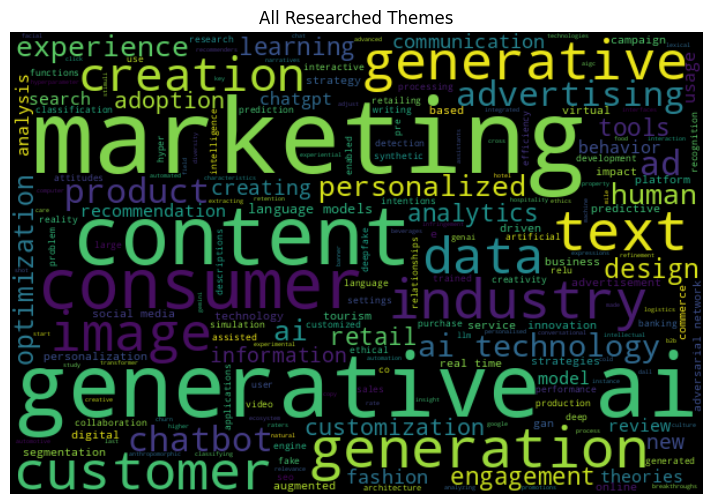

In [0]:

# Convert to Pandas DataFrame for plotting
filtered_themes_pd = themes_df.toPandas()

# Generate a horizontal barplot with different colors for each theme
plt.figure(figsize=(12, 6))
colors = plt.cm.tab20(range(len(filtered_themes_pd)))
from wordcloud import WordCloud

wordcloud = WordCloud(width=600, height=400, background_color='black').generate(' '.join(filtered_themes_pd['Theme']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.xlabel('Count', fontsize=10)
# plt.ylabel('Themes', fontsize=10)
plt.title('All Researched Themes', fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)
plt.show()

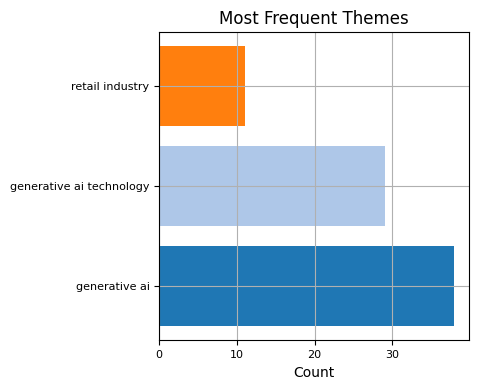

In [0]:
import matplotlib.pyplot as plt

# Filter themes_df where Count > 10
filtered_themes_df = themes_df.filter(themes_df['Count'] > 10)

# Convert to Pandas DataFrame for plotting
filtered_themes_pd = filtered_themes_df.toPandas()

# Generate a horizontal barplot with different colors for each theme
plt.figure(figsize=(4, 4))
colors = plt.cm.tab20(range(len(filtered_themes_pd)))
plt.barh(filtered_themes_pd['Theme'], filtered_themes_pd['Count'], color=colors)
plt.xlabel('Count', fontsize=10)
# plt.ylabel('Themes', fontsize=10)
plt.title('Most Frequent Themes', fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)
plt.show()

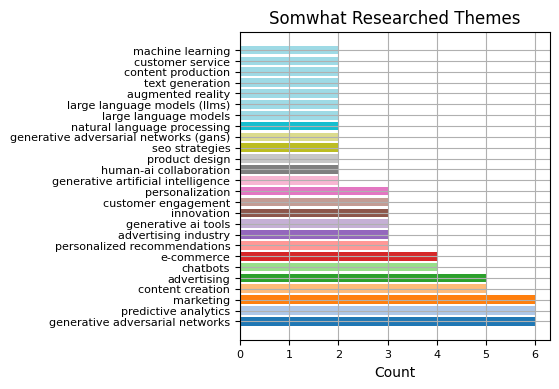

In [0]:
# Filter themes_df where Count > 10
filtered_themes_df = themes_df.filter((themes_df['Count'] > 1) & (themes_df['Count'] < 10))

# Convert to Pandas DataFrame for plotting
filtered_themes_pd = filtered_themes_df.toPandas()

# Generate a horizontal barplot with different colors for each theme
plt.figure(figsize=(4, 4))
colors = plt.cm.tab20(range(len(filtered_themes_pd)))
plt.barh(filtered_themes_pd['Theme'], filtered_themes_pd['Count'], color=colors)
plt.xlabel('Count', fontsize=10)
# plt.ylabel('Themes', fontsize=10)
plt.title('Somwhat Researched Themes', fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)
plt.show()

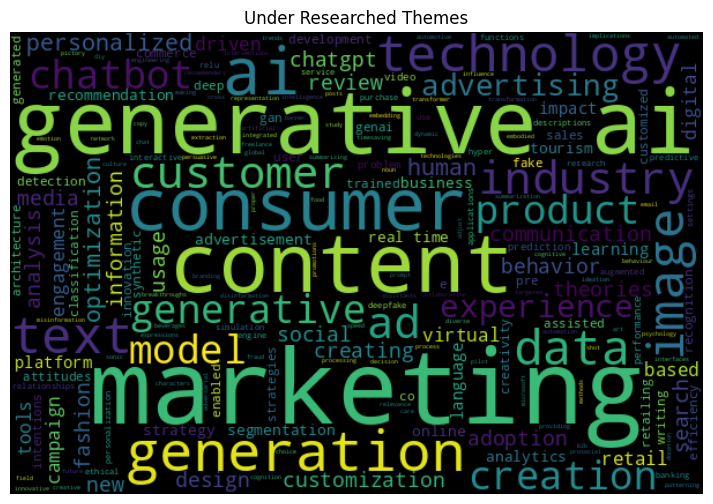

In [0]:
# Filter themes_df where Count > 10
filtered_themes_df = themes_df.filter((themes_df['Count'] <=1) )

# Convert to Pandas DataFrame for plotting
filtered_themes_pd = filtered_themes_df.toPandas()

# Generate a horizontal barplot with different colors for each theme
plt.figure(figsize=(12, 6))
colors = plt.cm.tab20(range(len(filtered_themes_pd)))
from wordcloud import WordCloud

wordcloud = WordCloud(width=600, height=400, background_color='black').generate(' '.join(filtered_themes_pd['Theme']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.xlabel('Count', fontsize=10)
# plt.ylabel('Themes', fontsize=10)
plt.title('Under Researched Themes', fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)
plt.show()

In [0]:
# result_df = pd.concat(final_df, df)
# display(result_df)

Based on the themes identified from research documents, where Gen-AI usage is indiated, separate those themes into technology and usecases

In [0]:
theme_classifier_system_prompt = "You are a AI assistant, who will be reviewing various themes identified from research papers to classify each theme between usecase, and technology. If a theme does not match either of the criteria, then classify it as other. Please provide the expected output in the format of {'Class':'Use-Case/Technology/Other'}. Do not generate any explaination text, only generate expected output."

        
theme_classifier_user_prompt = "Example1 Input= {'Theme': 'social media marketing'}. Expeced output is '{'Class':'Use-Case'}', Example1 Input= {'Theme': 'text analytics'}. Expeced output is '{'Class':'Technology'}', Example3 Input= {'Theme': 'prompt engineering'},  Expeced output is '{'Class':'Technology'}'."


theme_classifier_prompt_combo = "Please classify given theme and generate expected output for below set of input. "


In [0]:
## Converting from dataframe to list representation -- faster than creating a UDF for these tasks

data = themes_df.select(col("Theme")).collect()

initial_cal_llm_theme_classifier = []
for i in data:
    
    initial_cal_llm_theme_classifier.append({"Theme":i['Theme'] })

print(len(initial_cal_llm_theme_classifier))

303


In [0]:
def CallThemeClassifierLLM(theme):
    import time
     # Wait time
    time.sleep(5)
    # print("Calling parser with text:", text)
    #replace "" with single quote in text
    # try:
    #     text_= str(text).replace('"', "'")
    # except:
    #     text_ = text

    from openai import OpenAI
    import os
    # Set the OpenAI API key as an environment variable
    DATABRICKS_TOKEN = dbutils.notebook.entry_point.getDbutils().notebook().getContext().apiToken().get()

    os.environ['OPENAI_API_KEY'] = DATABRICKS_TOKEN#os.environ.get('DATABRICKS_TOKEN')

    client = OpenAI(
    api_key=os.environ['OPENAI_API_KEY'],
    base_url="https://adb-7018564609060221.1.azuredatabricks.net/serving-endpoints"
    )

    chat_completion = client.chat.completions.create(
    messages=[        
        {"role": "system", "content": theme_classifier_system_prompt +" "+ theme_classifier_user_prompt},
        {"role": "user", "content": theme_classifier_prompt_combo + " " + theme}

    ],
    model="databricks-mixtral-8x7b-instruct",
    max_tokens=4096
    )

    output_text = (chat_completion.choices[0].message.content)
    # print("original output:", output_text)
    # output_text = output_text.replace("Expected output: {'Class':", "")
    try:
        output_text = output_text.replace("{'Class':", "")

        output_text = output_text.replace("}", "")
        # print("Cleaned Output:",output_text)
    except:
        output_text = "Error"
    return output_text


In [0]:
from pyspark.sql.types import StructType, StructField, StringType
combo_list=[]
# Define the schema
schema = StructType([
    
    # StructField("Theme", StringType(), True),
    StructField("Class", StringType(), True)
    # Add other fields as necessary
])

for i in range(len(initial_cal_llm_theme_classifier)):

    
    combo = CallThemeClassifierLLM(str(initial_cal_llm_theme_classifier[i]))
    # print(combo)
    print(i,str(initial_cal_llm_theme_classifier[i]),"Class:",combo)  
    combo_list.append(combo)
    

print(combo_list)

0 {'Theme': 'generative ai'} Class:  'Technology'
1 {'Theme': 'generative ai technology'} Class:  'Technology'
2 {'Theme': 'retail industry'} Class:  'Use-Case'
3 {'Theme': 'generative adversarial networks'} Class:  'Technology'
4 {'Theme': 'predictive analytics'} Class:  'Technology'
5 {'Theme': 'marketing'} Class: 	'Use-Case'
6 {'Theme': 'advertising'} Class:  'Use-Case'
7 {'Theme': 'content creation'} Class: 	'Use-Case'
8 {'Theme': 'chatbots'} Class: 	'Use-Case'
9 {'Theme': 'e-commerce'} Class:  'Use-Case'
10 {'Theme': 'advertising industry'} Class: 	'Use-Case'
11 {'Theme': 'customer engagement'} Class: 	'Use-Case'
12 {'Theme': 'generative ai tools'} Class:  'Technology'
13 {'Theme': 'innovation'} Class: 	'Other'
14 {'Theme': 'personalized recommendations'} Class:  'Use-Case'
15 {'Theme': 'personalization'} Class: 	'Use-Case'
16 {'Theme': 'generative adversarial networks (gans)'} Class:  Expected output: 'Technology'
17 {'Theme': 'human-ai collaboration'} Class:  'Use-Case'
18 {'The